In [1]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import re
import warnings
import os

In [2]:
# Data load and pre-processing
oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\Brest_Sample_Oct_13_2022_precompute\\"
file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing')
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])
file_index = 0 #Process single file from list below
ds = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
antenna_ident = ss.utils.tools.antenna_idents(ds)
ds = ss.oscar.level1.fill_missing_variables(ds, antenna_ident)

OSCAR L1 processing
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Oct_13_2022_precompute\
-------------------
File index : 0 , Aquisition time : 20220517T093239 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220525T080646 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220525T085452 , File list indices : [6, 7, 8]


In [3]:
# L1 processing
for i in list(ds.keys()):
    ds[i] = ss.oscar.level1.check_antenna_polarization(ds[i])
    ds[i] = ss.oscar.level1.compute_multilooking_Master_Slave(ds[i], window=7)
    ds[i]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
    ds[i] = ss.oscar.level1.compute_antenna_azimuth_direction(ds[i], antenna=antenna_ident[list(ds.keys()).index(i)])
    ds[i] = ss.oscar.level1.compute_time_lag_Master_Slave(ds[i], options='from_SAR_time')
    ds[i] = ss.oscar.level1.compute_radial_surface_velocity(ds[i])
#Build L1 dataset
dsl1 = ss.oscar.level1.merge_beams(ds, antenna_ident)
# Generating geophysical data fields for GMF doppler computation
u10 = 7 # wind speed
wind_direction = 190 # wind direction
aux = ss.oscar.level1.init_auxiliary(dsl1,u10,wind_direction)
# Compute RSC
dsl1 = ss.oscar.level1.compute_radial_surface_current(dsl1.sel(Antenna=['Fore','Aft']), aux, gmf='mouche12')

#L2 Processing
# Initialise l2 dataset
dsl2=ss.oscar.level1.init_level2(dsl1)
# Compute current magnitude and direction
dsl2=seastar.retrieval.level2.compute_current_magnitude_and_direction(dsl1, dsl2)


In [4]:
# Load and colocate auxiliary data
xband_file="D:\data\SEASTAR\SEASTARex\Data\Hereon\Xband_radar_17th_may.mat"
ds_xband = ss.retrieval.auxiliary.colocate_xband_marine_radar_data(xband_file, dsl2)
ds_xband['CurrentMagnitude'], ds_xband['CurrentDirection'] =ss.retrieval.auxiliary.\
compute_Xband_current_magnitude_and_direction(ds_xband)


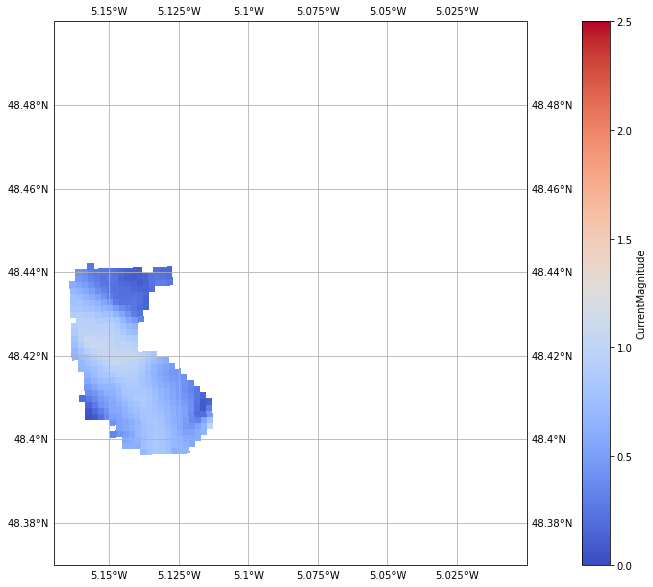

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
ds_xband.coarsen(GroundRange=20,boundary='trim').mean().coarsen(CrossRange=20,boundary='trim').mean().CurrentMagnitude.plot(
                                 y='latitude', x='longitude',
                                 robust=True, 
                                 cmap='coolwarm',
                                 vmin=0, vmax=2.5,
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5., 48.37, 48.5], crs=ccrs.PlateCarree())

In [ ]:
ax3 = dsf.OrbitHeadingImage.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )

ax3 = dsm.IncidenceAngleImage.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )

ax3 = dsa.IncidenceAngleImage.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )


In [ ]:
def inpaint_nans(im):
    ipn_kernel = np.array([[1,1,1],[1,0,1],[1,1,1]])
    nans = np.isnan(im)
    while np.sum(nans)>0:
        im[nans] = 0
        vNeighbors = signal.convolve2d((nans==False),ipn_kernel,mode='same',boundary='symm')
        im2 = signal.convolve2d(im,ipn_kernel,mode='same',boundary='symm')
        im2[vNeighbors>0] = im2[vNeighbors>0]/vNeighbors[vNeighbors>0]
        im2[vNeighbors==0] = np.nan
        im2[(nans==False)] = im[(nans==False)]
        im = im2
        nans = np.isnan(im)
    return im

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
ds_xband.coarsen(GroundRange=20,boundary='trim').mean().coarsen(CrossRange=20,boundary='trim').mean().CurrentMagnitude.plot(
                                 y='latitude', x='longitude',
                                 robust=True, 
                                 cmap='coolwarm',
                                 vmin=0, vmax=2.5,
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5., 48.37, 48.5], crs=ccrs.PlateCarree())

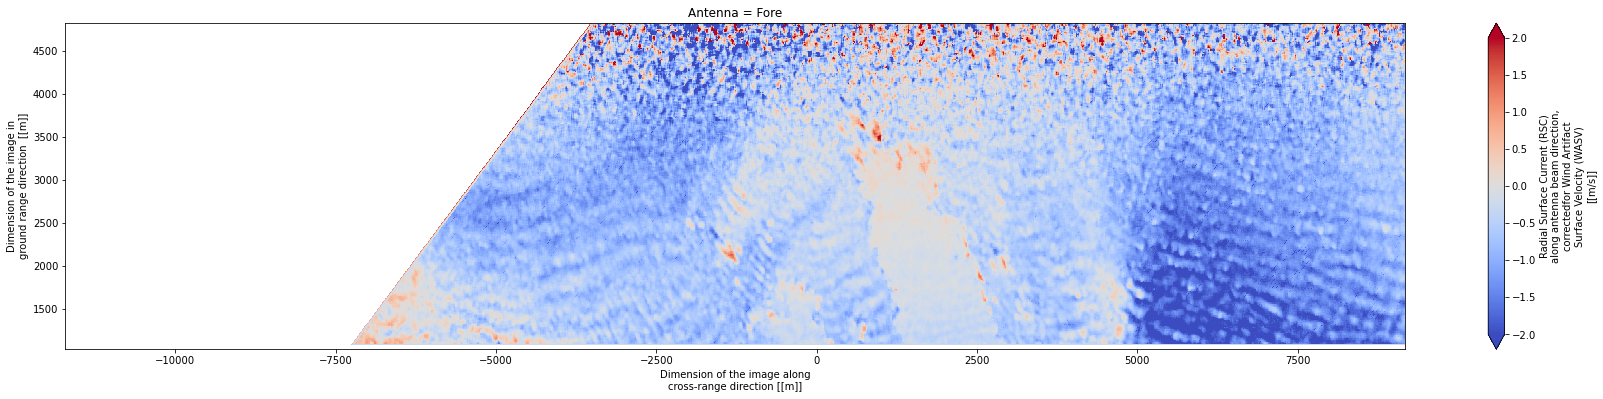

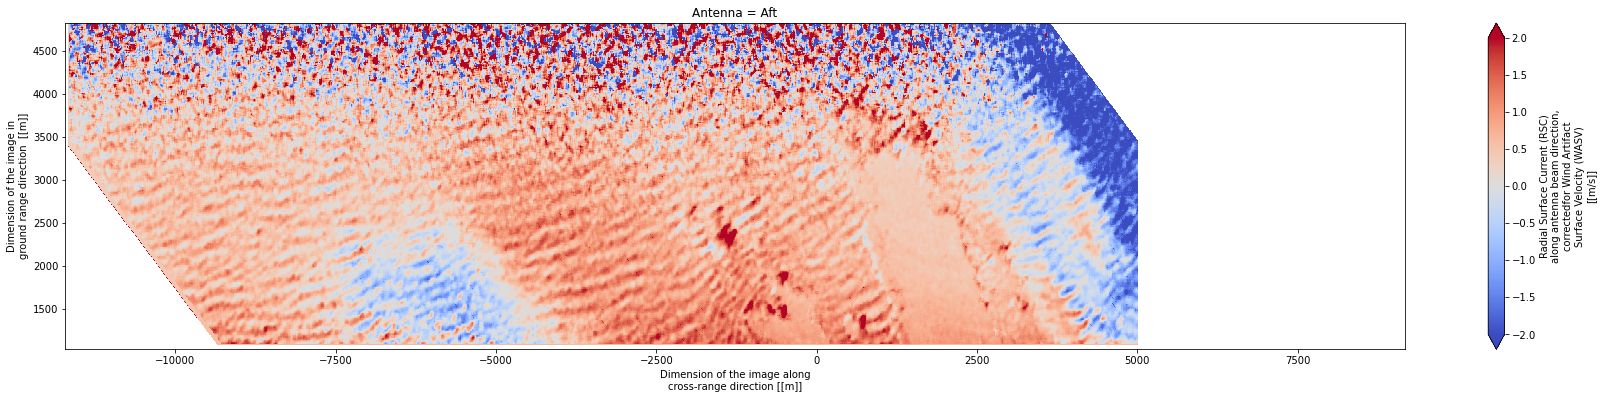

In [6]:
ax3 = dsl1.RadialSurfaceCurrent.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True, 
                                                         cmap='coolwarm',
                                                         vmin=-2,vmax=2
                      )
ax4 = dsl1.RadialSurfaceCurrent.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True, 
                                                        cmap='coolwarm',
                                                        vmin=-2,vmax=2
                                                       )

#vector_density=30
#ax4=plt.quiver(Y[::vector_density, ::vector_density],
#               X[::vector_density, ::vector_density],
#               level2.CurrentVectorUComponent[::vector_density, ::vector_density],
#               level2.CurrentVectorVComponent[::vector_density, ::vector_density])


In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2.CurrentDirection.plot(
                                 y='latitude', x='longitude',
                                 robust=True, 
                                 cmap='hsv',
                                 #vmin=0, vmax=10,
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5., 48.37, 48.5], crs=ccrs.PlateCarree())

In [ ]:
def compute_current_vectors(level2):
    
    level2['CurrentVectorUComponent']=level2.CurrentMagnitude *np.cos(np.radians(level2.CurrentDirection))
    level2['CurrentVectorVComponent']=level2.CurrentMagnitude *np.sin(np.radians(level2.CurrentDirection))
    
    return level2

In [ ]:
dsl2 = compute_current_vectors(dsl2)

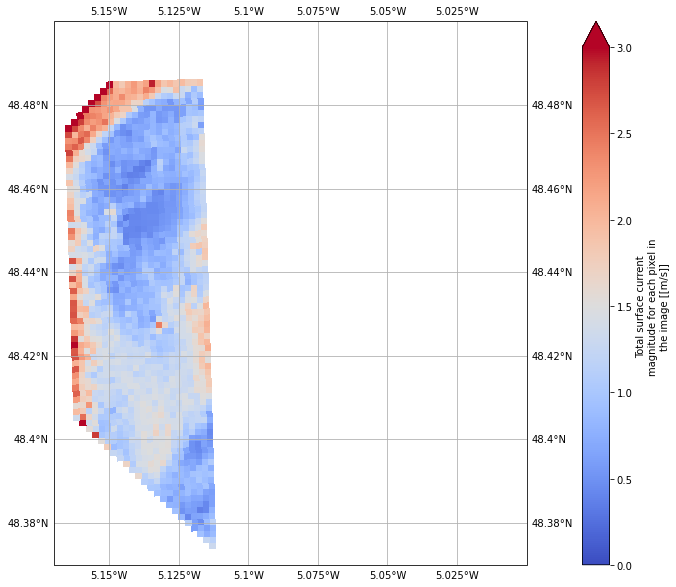

In [7]:

#X, Y = np.meshgrid(dsl2.longitude, dsl2.latitude, indexing='ij')
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
trim_factor=20
dsl2\
.coarsen(GroundRange=trim_factor,boundary='trim').mean()\
.coarsen(CrossRange=trim_factor,boundary='trim').mean()\
.CurrentMagnitude.plot(
    y='latitude', x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree()
)
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5., 48.37, 48.5], crs=ccrs.PlateCarree())

#X, Y = np.meshgrid(dsl2.longitude, dsl2.latitude, indexing='ij')
#vector_density=30
#plt.quiver(dsl2.latitude[::vector_density, ::vector_density],
#               dsl2.longitude[::vector_density, ::vector_density],
#               dsl2.CurrentVectorUComponent[::vector_density, ::vector_density],
#               dsl2.CurrentVectorVComponent[::vector_density, ::vector_density])

In [ ]:
trim_factor=20
direction_correction = -45

fig = plt.figure(figsize=(15, 30))
ax = fig.add_subplot(1,2,1, projection=ccrs.Mercator())

dsl2\
.coarsen(GroundRange=trim_factor,boundary='trim').mean()\
.coarsen(CrossRange=trim_factor,boundary='trim').mean()\
.CurrentDirection.plot(y='latitude', x='longitude',
                 robust=True, 
                 cmap='hsv',
                 #vmin=0, vmax=3,
                 transform=ccrs.PlateCarree(),
                 #add_colorbar=False
                )
#plt.title('OSCAR surface current magnitude (m/s)')
ax2 = fig.add_subplot(1,2,2, projection=ccrs.Mercator())
ds_xband\
.coarsen(GroundRange=trim_factor,boundary='trim').mean()\
.coarsen(CrossRange=trim_factor,boundary='trim').mean()\
.CurrentDirection.plot(y='latitude', x='longitude',
                 robust=True, 
                 cmap='hsv',
                # vmin=0, vmax=3,
                 transform=ccrs.PlateCarree(),
                 #add_colorbar=False
                )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())

gl=ax2.gridlines(draw_labels=True)
ax2.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())

In [ ]:
trim_factor = 1




fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=ds_xband\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentDirection.values.flatten(), 
    y=np.mod(dsl2+45, 360)\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentDirection.values.flatten(),
    gridsize=100,
    cmap='gist_yarg',
)

plt.xlim([200,360])
plt.ylim([200,360])
plt.plot([200,360],[200,360],'k')
#plt.axis('equal')
#plt.title('Derived surface currents')
plt.xlabel('X-band derived surface current (m/s)')
plt.ylabel('OSCAR surface current (m/s)')
#ax.set(xticklabels=[])

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2.CurrentMagnitude.plot(
                                 y='latitude', x='longitude',
                                 robust=True, 
                                 #cmap='hot',
                     add_colorbar=False,
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2.CurrentDirection.plot(
                                 y='latitude', x='longitude',
                                 robust=True, 
                                 cmap='hsv',
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())

In [ ]:
ax1 = ds_xband.CurrentDirection.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='hsv',
                                                        #vmin=0,vmax=2
                      )
ax2 = dsl2.CurrentDirection.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='hsv',
                                                       # vmin=0,vmax=2
                      )
#X, Y = np.meshgrid(dsl2.CrossRange, dsl2.GroundRange, indexing='ij')
#vector_density=30
#plt.quiver(X[::vector_density, ::vector_density],
#               Y[::vector_density, ::vector_density],
#               dsl2.CurrentVectorVComponent[::vector_density, ::vector_density],
#               dsl2.CurrentVectorUComponent[::vector_density, ::vector_density])
